# SAT & ACT Data Exploration

----------------------------------------------

# Problem Statement

The new format for the SAT was released in March 2016. As an employee of the College Board - the organization that administers the SAT - you are a part of a team that tracks statewide participation and recommends where money is best spent to improve SAT participation rates. Your presentation and report should be geared toward non-technical executives with the College Board and you will use the provided data and outside research to make recommendations about how the College Board might work to increase the participation rate in a state of your choice.

Considerations:

What are the states that have the lowest participation rates?
Which states are worth putting money in to improve participation rates?
It might be worth considering those with potential (higher scores than others) but lower participation than others, compared with those with low participation but low potential
It will be worth comparing SAT vs ACT participation rates and scores to see where SAT participation falls short of ACT participation for states with low participation but good potential scores.

## Executive Summary

### Contents:
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Data Visualization](#Visualize-the-Data)
- [Descriptive and Inferential Statistics](#Descriptive-and-Inferential-Statistics)
- [Outside Research](#Outside-Research)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)

##### Importing Python Libraries

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import utility as u
import re
pd.options.display.max_columns=1000            ### Please don't try to display all columns

In [2]:
### Helper functions in u.py

def fmt_percentage(x):
    # strip % symbol
    if type(x) == str:
        x = x.replace("%", "")
        # change to float
        x = float(x)/100    

    elif type(x) in [int,float]:
        x = float(x)/100    
        
    return x

def official_states():
    # official states in our data    
    states = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware',              
          'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 
          'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 
          'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 
          'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 
          'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 
          'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']

    return states

def rm_unofficial_states(df, state_colname):
    """ remove states in df which are not in our official states list
    """
    states = official_states()    

    for i in list(df[state_colname]):
        if i not in states:
            print("{} shouldn't be in df, removing...".format(i))
    
    df = df[df[state_colname].isin(states)]
    return df

def check_states_len(df, state_colname):
    """ checks if len(df) is the same as our official states. we expect every state to be represented and no duplicates
    """
    states = official_states()    
    if len(df[state_colname]) > len(states):
        print("there is an extra state")
    elif len(df[state_colname]) < len(states):
        print("some states are missing")
    elif len(df[state_colname]) == len(states):
        print("seems every state is here")
    
def fmt_cols(df):    
    # Change 'Evidence-Based Reading and Writing' to 'ERW'
    df = df.rename(columns={"Evidence-Based Reading and Writing":"ERW",
                            "Participation":"Pax",
                            "Participation Rate":"Pax",
                            "English":"Eng",
                            "Reading":"Readg",
                            "Science":"Sci",
                            "Composite":"Cpsite",                            
                            "Mathematics":"Math",
                            "Percentage of Students Tested":"Pax",
                            "Average Composite Score":"Cpsite",
                            "Average English Score":"Eng",
                            "Average Math Score":"Math",
                            "Average Reading Score":"Readg",
                            "Average Science Score":"Sci"})

    new_col_names = [i.lower() for i in df.columns]

    df.columns = new_col_names 
    return df

def fix_type(df):
    for i in df.columns:
        if type(df.loc[0, i]) == str:
            df[i].apply(lambda x: clean_float(x))
            
def clean_float(x):
    # takes only the numeric portion
    x = re.search("(\d+)", "20.2x").group(1)
    x = float(x)
    return x

def fmt_data(df):
    # formats the percentage to float in 'Participation'
    df.pax = df.pax.apply(fmt_percentage)

    return df

def redo_total(df, cols_for_total, total_col):
    """ re-calculates sum based on numbers in df[cols_for_total] and store it in the df[total_col]
    """
    total = df[cols_for_total].sum(axis=1)
    if list(total) == list(df[total_col]):
        print("Nothing wrong for df[{}]".format(total_col))
    else:
        print("Total does not match... replacing")
        df[total_col] = total                               ### Doesn't this assume that the total is wrong but 
    return df                                               ### not the summands?

def find_diff(df1, df2):    
    """ finds differences in contents for all columns in df1 and df2. df1 and df2 has to have the same columns and same dtypes for each column
    """
    compare = pd.concat([df1, df2]) #GA-provided data above, web-sourced data below
    compare = compare.reset_index(drop=True)
    compare_grouped = compare.groupby(list(compare.columns))
    idx = [x[0] for x in compare_grouped.groups.values() if len(x) == 1]
    compare = compare.reindex(idx) 
    
    return compare

def reorder_sat(df):
    return df[['state','pax','erw','math','total']]

def reorder_act(df):
    return df[['state', 'pax', 'eng', 'math', 'readg', 'sci', 'cpsite']]

## 2017 Data Import and Cleaning

### Import SAT & ACT  Data

Read in the `sat_2017.csv` and `act_2017.csv` files and assign them to appropriately named pandas dataframes.

## Work on SAT (2017) Dataset

##### Preliminary checks

In [3]:
!pwd                   ### Very good

C:\Users\Jonathan\Desktop\Project_1_Marking\Group_2_siti_aishah\aishahmad-master\P1_SAT-ACT-Analysis\1_notebooks


pwd: ignoring non-option arguments


In [4]:
sat = pd.read_csv('../2_data/raw/sat_2017.csv')
sat.head()

,State,Participation,Evidence-Based Reading and Writing,Math,Total
0,Alabama,5%,593,572,1165
1,Alaska,38%,547,533,1080
2,Arizona,30%,563,553,1116
3,Arkansas,3%,614,594,1208
4,California,53%,531,524,1055


##### Check and change datatypes

In [5]:
# formats col names in sat 
sat = u.fmt_cols(sat)

# formats data in sat 
sat = u.fmt_data(sat)

# clean and check our states
sat = u.rm_unofficial_states(sat, "state")
u.check_states_len(sat, "state")

sat = u.reorder_sat(sat)

sat.head(10)

seems every state is here


,state,pax,erw,math,total
0,Alabama,0.05,593,572,1165
1,Alaska,0.38,547,533,1080
2,Arizona,0.30,563,553,1116
3,Arkansas,0.03,614,594,1208
4,California,0.53,531,524,1055
5,Colorado,0.11,606,595,1201
6,Connecticut,1.00,530,512,1041
7,Delaware,1.00,503,492,996
8,District of Columbia,1.00,482,468,950
9,Florida,0.83,520,497,1017


In [6]:
# just in case, re-do our "Total"
sat = u.redo_total(sat, ["erw","math"], "total")

Total does not match... replacing


##### Compare with web-sourced data, check for errors

*SAT 2017 Data taken from source websites and saved into csv files for comparison*
- [SAT 2017](https://blog.collegevine.com/here-are-the-average-sat-scores-by-state) | sat_2017_web.csv

In [7]:
#Import data from web & process

sat_web = pd.read_csv('../2_data/external/sat_2017_web.csv')
sat_web = u.fmt_cols(sat_web)
sat_web = u.fmt_data(sat_web) 
sat_web = u.rm_unofficial_states(sat_web, "state")
u.check_states_len(sat_web, "state")
sat_web = u.redo_total(sat_web, ["erw","math"], "total") # even the web data is wrong here
sat_web = u.reorder_sat(sat_web)

sat_web.head()

seems every state is here
Total does not match... replacing


,state,pax,erw,math,total
0,Alabama,0.05,593,572,1165
1,Alaska,0.38,547,533,1080
2,Arizona,0.30,563,553,1116
3,Arkansas,0.03,614,594,1208
4,California,0.53,531,524,1055


##### Compare differences between web-sourced csv and GA-provided csv

*Use this block of code from [stackoverflow](https://stackoverflow.com/questions/20225110/comparing-two-dataframes-and-getting-the-differences/20228113#20228113) to concatenate and shortlist differences in 2 dataframes we are interested to compare*

In [8]:
u.find_diff(sat, sat_web)

,state,pax,erw,math,total
20,Maryland,0.69,536,52,588
71,Maryland,0.69,536,524,1060


- *error in Maryland Math score*

##### Fix erroneous data

In [9]:
# Replace erroneous data in sat df 
# or simply overwrite sat df with sat_from_web to keep sat df accurate
sat = sat_web

In [10]:
#Check if any more differences
u.find_diff(sat, sat_web)

,state,pax,erw,math,total


## Work on ACT (2017) Dataset

##### Import GA-provided ACT 2017 csv

In [11]:
act = pd.read_csv('../2_data/raw/act_2017.csv')
act.head()

,State,Participation,English,Math,Reading,Science,Composite
0,National,60%,20.3,20.7,21.4,21.0,21.0
1,Alabama,100%,18.9,18.4,19.7,19.4,19.2
2,Alaska,65%,18.7,19.8,20.4,19.9,19.8
3,Arizona,62%,18.6,19.8,20.1,19.8,19.7
4,Arkansas,100%,18.9,19.0,19.7,19.5,19.4


In [12]:
act = u.fmt_cols(act)
act = u.fmt_data(act) 
act = u.rm_unofficial_states(act, "state")
u.check_states_len(act, "state")
act = u.reorder_act(act)

act.head()

National shouldn't be in df, removing...
seems every state is here


,state,pax,eng,math,readg,sci,cpsite
1,Alabama,1.00,18.9,18.4,19.7,19.4,19.2
2,Alaska,0.65,18.7,19.8,20.4,19.9,19.8
3,Arizona,0.62,18.6,19.8,20.1,19.8,19.7
4,Arkansas,1.00,18.9,19.0,19.7,19.5,19.4
5,California,0.31,22.5,22.7,23.1,22.2,22.8


##### Compare given data against web source data

*ACT 2017 Data taken from source websites and saved into csv files for comparison*
- [ACT 2017](https://blog.prepscholar.com/act-scores-by-state-averages-highs-and-lows) | act_2017_web.csv

In [13]:
#Import data
act_web = pd.read_csv('../2_data/external/act_2017_web.csv')
act_web.head()

,State,Participation,English,Math,Reading,Science,Composite
0,Alabama,100%,18.9,18.4,19.7,19.4,19.2
1,Alaska,65%,18.7,19.8,20.4,19.9,19.8
2,Arizona,62%,18.6,19.8,20.1,19.8,19.7
3,Arkansas,100%,18.9,19.0,19.7,19.5,19.4
4,California,31%,22.5,22.7,23.1,22.2,22.8


In [14]:
#Standardise formats
act_web = u.fmt_cols(act_web)
act_web = u.fmt_data(act_web) 
act_web = u.rm_unofficial_states(act_web, "state")
u.check_states_len(act_web, "state")
act_web = u.reorder_act(act_web)

act_web.head()

seems every state is here


,state,pax,eng,math,readg,sci,cpsite
0,Alabama,1.00,18.9,18.4,19.7,19.4,19.2
1,Alaska,0.65,18.7,19.8,20.4,19.9,19.8
2,Arizona,0.62,18.6,19.8,20.1,19.8,19.7
3,Arkansas,1.00,18.9,19.0,19.7,19.5,19.4
4,California,0.31,22.5,22.7,23.1,22.2,22.8


In [15]:
#Find differences
u.find_diff(act, act_web)

,state,pax,eng,math,readg,sci,cpsite
0,Alabama,1.00,18.9,18.4,19.7,19.4,19.2
1,Alaska,0.65,18.7,19.8,20.4,19.9,19.8
2,Arizona,0.62,18.6,19.8,20.1,19.8,19.7
3,Arkansas,1.00,18.9,19.0,19.7,19.5,19.4
4,California,0.31,22.5,22.7,23.1,22.2,22.8
...,...,...,...,...,...,...,...
97,Virginia,0.29,23.5,23.3,24.6,23.5,23.8
98,Washington,0.29,20.9,21.9,22.1,22.0,21.9
99,West Virginia,0.69,20.0,19.4,21.2,20.5,20.4
100,Wisconsin,1.00,19.7,20.4,20.6,20.9,20.5


- *All entries 'different'*

In [16]:
act.dtypes

state      object
pax       float64
eng       float64
math      float64
readg     float64
sci       float64
cpsite     object
dtype: object

In [17]:
act

,state,pax,eng,math,readg,sci,cpsite
1,Alabama,1.00,18.9,18.4,19.7,19.4,19.2
2,Alaska,0.65,18.7,19.8,20.4,19.9,19.8
3,Arizona,0.62,18.6,19.8,20.1,19.8,19.7
4,Arkansas,1.00,18.9,19.0,19.7,19.5,19.4
5,California,0.31,22.5,22.7,23.1,22.2,22.8
6,Colorado,1.00,20.1,20.3,21.2,20.9,20.8
7,Connecticut,0.31,25.5,24.6,25.6,24.6,25.2
8,Delaware,0.18,24.1,23.4,24.8,23.6,24.1
9,District of Columbia,0.32,24.4,23.5,24.9,23.5,24.2
10,Florida,0.73,19.0,19.4,21.0,19.4,19.8


##### Change error in Wyoming Composite '20.2x'
*Trying to change dtype of Composite column to float above threw an error '20.2x'*

In [18]:
act.loc[act.state=='Wyoming', 'cpsite'] = 20.2

In [19]:
#Change to float
act.cpsite = act.cpsite.astype(float)

In [20]:
#Find differences
u.find_diff(act, act_web)

,state,pax,eng,math,readg,sci,cpsite
20,Maryland,0.28,23.3,23.1,24.2,2.3,23.6
71,Maryland,0.28,23.3,23.1,24.2,23.2,23.6


##### Correct Maryland data

*Error in Maryland Science entry in GA-provided csv*

In [21]:
act.loc[act.state=="Maryland",'sci'] = 23.2 #correct the value in original act df
act.loc[act.state=="Maryland"]

,state,pax,eng,math,readg,sci,cpsite
21,Maryland,0.28,23.3,23.1,24.2,23.2,23.6


In [22]:
u.find_diff(act, act_web)

,state,pax,eng,math,readg,sci,cpsite


- *No more errors*

## Merge SAT 2017 and ACT 2017 Tables

In [23]:
combined_2017 = sat.merge(act, how="left", on="state", suffixes=('_sat', '_act'))  ### Good
combined_2017.tail()

,state,pax_sat,erw,math_sat,total,pax_act,eng,math_act,readg,sci,cpsite
46,Virginia,0.65,561,541,1102,0.29,23.5,23.3,24.6,23.5,23.8
47,Washington,0.64,541,534,1075,0.29,20.9,21.9,22.1,22.0,21.9
48,West Virginia,0.14,558,528,1086,0.69,20.0,19.4,21.2,20.5,20.4
49,Wisconsin,0.03,642,649,1291,1.00,19.7,20.4,20.6,20.9,20.5
50,Wyoming,0.03,626,604,1230,1.00,19.4,19.8,20.8,20.6,20.2


##### Export Data

In [24]:
combined_2017.to_csv('../2_data/processed/combined_2017.csv',index=False)

### Describe Data

Take your time looking through the data and thoroughly describe the data in the markdown cell below. 

SAT_2017.csv

51 states arranged by alphabetical order
- participation rate of each state in the SAT test in %
- the sections of the SAT 2017 test (Evidence-Based Reading and Writing) with likely the mean score of each section in the test
- the sum of mean section scores (Total)
- error in Maryland score

https://blog.prepscholar.com/sat-sections

ACT_2017.csv

1 extra row called 'National' on top of the 51 states, arranged by alphabetical order
- participation rate of each state in the ACT test in %
- the 4 sections of the ACT 2017 test (English, Math, Reading, Science) with likely the mean score of each section in the test
- the final mean score of the test (Composite)

- error in Wyoming in the Composite score data (20.2x)

https://www.thoughtco.com/act-scoring-details-3211160

In [25]:
combined_2017.describe()

,pax_sat,erw,math_sat,total,pax_act,eng,math_act,readg,sci,cpsite
count,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
mean,0.398039,569.117647,556.882353,1126.000000,0.652549,20.931373,21.182353,22.013725,21.450980,21.519608
std,0.352766,45.666901,47.121395,92.487621,0.321408,2.353677,1.981989,2.067271,1.739353,2.020695
min,0.020000,482.000000,468.000000,950.000000,0.080000,16.300000,18.000000,18.100000,18.200000,17.800000
25%,0.040000,533.500000,523.500000,1055.500000,0.310000,19.000000,19.400000,20.450000,19.950000,19.800000
50%,0.380000,559.000000,548.000000,1106.000000,0.690000,20.700000,20.900000,21.800000,21.300000,21.400000
75%,0.660000,613.000000,599.000000,1211.500000,1.000000,23.300000,23.100000,24.150000,23.200000,23.600000
max,1.000000,644.000000,651.000000,1295.000000,1.000000,25.500000,25.300000,26.000000,24.900000,25.500000


-------------------------------------------

## 2018 Data Import and Cleaning

Links to the 2018 ACT and SAT data are provided in the README. These data live in PDFs, and so you'll get to enjoy practicing some *manual* data collection. Save these data as a CSV in your `data` directory, and import, explore, and clean these data in the same way you did above. **Make sure you comment on your steps so it is clear *why* you are doing each process**.

*[Link](https://reports.collegeboard.org/sat-suite-program-results/state-results) for 2018 SAT in README directs to 2019 SAT State Results instead* 

*Using sat_2018.csv and act_2018_updated.csv pre-provided in the repo instead*

## Work on SAT (2018) Data

##### Import SAT 2018 Data from GA-provided csv's

In [26]:
sat18 = pd.read_csv('../2_data/raw/sat_2018.csv')

##### Preliminary check

In [27]:
sat18.tail(3)

,State,Participation,Evidence-Based Reading and Writing,Math,Total
48,West Virginia,28%,513,486,999
49,Wisconsin,3%,641,653,1294
50,Wyoming,3%,633,625,1257


##### Reformatting dataframe to be consistent with SAT 2017

In [28]:
sat18 = u.fmt_cols(sat18)
sat18 = u.fmt_data(sat18) 
sat18 = u.rm_unofficial_states(sat18, "state")
u.check_states_len(sat18, "state")
sat18 = u.redo_total(sat18, ["erw","math"], "total") # even the web data is wrong here

sat18.head()

seems every state is here
Total does not match... replacing


,state,pax,erw,math,total
0,Alabama,0.06,595,571,1166
1,Alaska,0.43,562,544,1106
2,Arizona,0.29,577,572,1149
3,Arkansas,0.05,592,576,1168
4,California,0.60,540,536,1076


##### Check and change data types

In [29]:
sat18.dtypes

state     object
pax      float64
erw        int64
math       int64
total      int64
dtype: object

##### Compare against web-based data for errors

- *source (https://ipsr.ku.edu/ksdata/ksah/education/6ed16.pdf) scraped into SAT_2017_2018_from_webpdf.xlsx*

In [30]:
#Import
sat18_web = pd.read_excel('../2_data/external/SAT_2017_2018_from_webpdf.xlsx', sheet_name='SAT2018') ### Good
sat18_web.tail()

,State,ERW,Mathematics,Total,Participation Rate
47,Washington,543,538,1081,69
48,West Virginia,513,486,999,28
49,Wisconsin,641,653,1294,3
50,Wyoming,633,625,1257,3
51,United States,536,531,1068,58


In [31]:
#Reformat dataframe
sat18_web = u.fmt_cols(sat18_web)
sat18_web = u.fmt_data(sat18_web) 
sat18_web = u.rm_unofficial_states(sat18_web, "state")
u.check_states_len(sat18_web, "state")
sat18_web = u.redo_total(sat18_web, ["erw","math"], "total") # even the web data is wrong here
sat18_web = u.reorder_sat(sat18_web)

sat18_web.tail()

United States shouldn't be in df, removing...
seems every state is here
Total does not match... replacing


,state,pax,erw,math,total
46,Virginia,0.68,567,550,1117
47,Washington,0.69,543,538,1081
48,West Virginia,0.28,513,486,999
49,Wisconsin,0.03,641,653,1294
50,Wyoming,0.03,633,625,1258


In [32]:
u.find_diff(sat18, sat18_web)

,state,pax,erw,math,total
9,Florida,0.56,550,549,1099
60,Florida,0.97,522,493,1015
11,Hawaii,0.56,480,530,1010
62,Hawaii,0.56,550,549,1099
14,Indiana,0.63,542,532,1074
65,Indiana,0.67,546,539,1085
44,Utah,0.04,480,530,1010
95,Utah,0.04,618,612,1230


- *4 differences in state data between GA-provided csv with corrected web-source data*
- *randomly checked Florida's [2017 SAT assessment report](https://reports.collegeboard.org/pdf/2017-florida-sat-suite-assessments-annual-report.pdf) with [2018 SAT assessment report](https://reports.collegeboard.org/pdf/2018-florida-sat-suite-assessments-annual-report.pdf) against GA's csv and [web-source pdf](https://ipsr.ku.edu/ksdata/ksah/education/6ed16.pdf), web-sourced pdf reflected correct participation values*
- *I assume the correct web-sourced values to be more accurate than the raw data for all states and will overwrite sat18 df with the more accurate one*

##### Finalise SAT 2018 data

In [33]:
#Pass into new dataframe name
sat18 = sat18_web
sat18.iloc[[9,11,14,44]] #to check values are corrected in these 5 states

,state,pax,erw,math,total
9,Florida,0.97,522,493,1015
11,Hawaii,0.56,550,549,1099
14,Indiana,0.67,546,539,1085
44,Utah,0.04,618,612,1230


In [34]:
u.find_diff(sat18, sat18_web)

,state,pax,erw,math,total


## Work on ACT (2018) Data

In [35]:
#Import
act18 = pd.read_csv('../2_data/raw/act_2018_updated.csv')
act18.tail(3)

,State,Percentage of Students Tested,Average Composite Score,Average English Score,Average Math Score,Average Reading Score,Average Science Score
48,West Virginia,65,20.3,19.8,19.4,21.3,20.4
49,Wisconsin,100,20.5,19.8,20.3,20.6,20.8
50,Wyoming,100,20.0,19.0,19.7,20.6,20.3


In [36]:
#Reformat dataframe
act18 = u.fmt_cols(act18)
act18 = u.fmt_data(act18) 
act18 = u.rm_unofficial_states(act18, "state")
u.check_states_len(act18, "state")
act18 = u.reorder_act(act18)

act18.tail()

seems every state is here


,state,pax,eng,math,readg,sci,cpsite
46,Virginia,0.24,23.8,23.3,24.7,23.5,23.9
47,Washington,0.24,21.4,22.2,22.7,22.0,22.2
48,West Virginia,0.65,19.8,19.4,21.3,20.4,20.3
49,Wisconsin,1.00,19.8,20.3,20.6,20.8,20.5
50,Wyoming,1.00,19.0,19.7,20.6,20.3,20.0


In [37]:
act18.dtypes

state      object
pax       float64
eng       float64
math      float64
readg     float64
sci       float64
cpsite    float64
dtype: object

### Importing ACT 2018 Data from Web Source

In [38]:
# None here

## Merge SAT 2018 and ACT 2018 Tables

##### Merge tables

In [39]:
combined_2018 = sat18.merge(act18, how='left', on='state', suffixes=('_sat','_act'))
combined_2018.loc[7:9,:]

,state,pax_sat,erw,math_sat,total,pax_act,eng,math_act,readg,sci,cpsite
7,Delaware,1.00,505,492,997,0.17,23.7,23.1,24.5,23.4,23.2
8,District of Columbia,0.92,497,480,977,0.32,23.7,22.7,24.4,23.0,23.6
9,Florida,0.97,522,493,1015,0.66,19.2,19.3,21.1,19.5,19.9


##### Export to csv if useful for later

In [40]:
combined_2018.to_csv('../2_data/processed/combined_2018.csv', index=False)

## Combine your 2017 and 2018 data into a single dataframe

Joining on state names should work, assuming you formatted all your state names identically. Make sure none of your columns (other than state) have identical names. Do yourself a favor and decide if you're encoding participation rates as floats or integers and standardize this across your datasets.

Save the contents of this merged dataframe as `final.csv`.

**Use this combined dataframe for the remainder of the project**.

In [41]:
final = combined_2017.merge(combined_2018, how='left', on='state', suffixes=('_17','_18'))
final.head()

,state,pax_sat_17,erw_17,math_sat_17,total_17,pax_act_17,eng_17,math_act_17,readg_17,sci_17,cpsite_17,pax_sat_18,erw_18,math_sat_18,total_18,pax_act_18,eng_18,math_act_18,readg_18,sci_18,cpsite_18
0,Alabama,0.05,593,572,1165,1.00,18.9,18.4,19.7,19.4,19.2,0.06,595,571,1166,1.00,18.9,18.3,19.6,19.0,19.1
1,Alaska,0.38,547,533,1080,0.65,18.7,19.8,20.4,19.9,19.8,0.43,562,544,1106,0.33,19.8,20.6,21.6,20.7,20.8
2,Arizona,0.30,563,553,1116,0.62,18.6,19.8,20.1,19.8,19.7,0.29,577,572,1149,0.66,18.2,19.4,19.5,19.2,19.2
3,Arkansas,0.03,614,594,1208,1.00,18.9,19.0,19.7,19.5,19.4,0.05,592,576,1168,1.00,19.1,18.9,19.7,19.4,19.4
4,California,0.53,531,524,1055,0.31,22.5,22.7,23.1,22.2,22.8,0.60,540,536,1076,0.27,22.5,22.5,23.0,22.1,22.7


##### Rename headers to make more readable in notebook

In [42]:
final.columns

Index(['state', 'pax_sat_17', 'erw_17', 'math_sat_17', 'total_17',
       'pax_act_17', 'eng_17', 'math_act_17', 'readg_17', 'sci_17',
       'cpsite_17', 'pax_sat_18', 'erw_18', 'math_sat_18', 'total_18',
       'pax_act_18', 'eng_18', 'math_act_18', 'readg_18', 'sci_18',
       'cpsite_18'],
      dtype='object')

In [43]:
rename_cols = {
    'pax_sat_17':'sat17_pax', 
    'erw_17':'sat17_erw', 
    'math_sat_17':'sat17_math', 
    'total_17':'sat17_total',
    'pax_act_17':'act17_pax', 
    'eng_17':'act17_eng', 
    'math_act_17':'act17_math', 
    'readg_17':'act17_readg', 
    'sci_17':'act17_sci',
    'cpsite_17':'act17_cpsite', 
    'pax_sat_18':'sat18_pax', 
    'erw_18':'sat18_erw', 
    'math_sat_18':'sat18_math', 
    'total_18':'sat18_total',
    'pax_act_18':'act18_pax', 
    'eng_18':'act18_eng', 
    'math_act_18':'act18_math', 
    'readg_18':'act18_readg', 
    'sci_18':'act18_sci',
    'cpsite_18':'act18_cpsite'
    }

In [44]:
final = final.rename(columns=rename_cols)
final.loc[18:22]

,state,sat17_pax,sat17_erw,sat17_math,sat17_total,act17_pax,act17_eng,act17_math,act17_readg,act17_sci,act17_cpsite,sat18_pax,sat18_erw,sat18_math,sat18_total,act18_pax,act18_eng,act18_math,act18_readg,act18_sci,act18_cpsite
18,Louisiana,0.04,611,586,1197,1.00,19.4,18.8,19.8,19.6,19.5,0.04,615,595,1210,1.00,19.0,18.5,19.6,19.1,19.2
19,Maine,0.95,513,499,1012,0.08,24.2,24.0,24.8,23.7,24.3,0.99,512,501,1013,0.07,23.8,23.6,24.7,23.4,24.0
20,Maryland,0.69,536,524,1060,0.28,23.3,23.1,24.2,23.2,23.6,0.76,545,535,1080,0.31,22.1,22.0,23.1,22.2,22.5
21,Massachusetts,0.76,555,551,1106,0.29,25.4,25.3,25.9,24.7,25.4,0.80,562,563,1125,0.25,25.5,25.2,25.9,24.7,25.5
22,Michigan,1.00,509,495,1004,0.29,24.1,23.7,24.5,23.8,24.1,1.00,511,499,1010,0.22,24.5,23.9,24.7,23.9,24.4


# Finalize data and export to final.csv

In [45]:
#Export to final.csv
final.to_csv('../2_data/processed/final.csv', index=False)

# Data Analysis

##### Importing Python Libraries

In [46]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import utility as u
import re
pd.options.display.max_columns=1000
pd.options.display.max_rows=100

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


##### Importing final.csv

In [47]:
!pwd

C:\Users\Jonathan\Desktop\Project_1_Marking\Group_2_siti_aishah\aishahmad-master\P1_SAT-ACT-Analysis\1_notebooks


In [48]:
final = pd.read_csv('../2_data/processed/final.csv')
final.tail()

,state,sat17_pax,sat17_erw,sat17_math,sat17_total,act17_pax,act17_eng,act17_math,act17_readg,act17_sci,act17_cpsite,sat18_pax,sat18_erw,sat18_math,sat18_total,act18_pax,act18_eng,act18_math,act18_readg,act18_sci,act18_cpsite
46,Virginia,0.65,561,541,1102,0.29,23.5,23.3,24.6,23.5,23.8,0.68,567,550,1117,0.24,23.8,23.3,24.7,23.5,23.9
47,Washington,0.64,541,534,1075,0.29,20.9,21.9,22.1,22.0,21.9,0.69,543,538,1081,0.24,21.4,22.2,22.7,22.0,22.2
48,West Virginia,0.14,558,528,1086,0.69,20.0,19.4,21.2,20.5,20.4,0.28,513,486,999,0.65,19.8,19.4,21.3,20.4,20.3
49,Wisconsin,0.03,642,649,1291,1.00,19.7,20.4,20.6,20.9,20.5,0.03,641,653,1294,1.00,19.8,20.3,20.6,20.8,20.5
50,Wyoming,0.03,626,604,1230,1.00,19.4,19.8,20.8,20.6,20.2,0.03,633,625,1258,1.00,19.0,19.7,20.6,20.3,20.0


## Exploratory Data Analysis

### Summary Statistics

Transpose the output of pandas `describe` method to create a quick overview of each numeric feature.

In [49]:
final.head(3)

,state,sat17_pax,sat17_erw,sat17_math,sat17_total,act17_pax,act17_eng,act17_math,act17_readg,act17_sci,act17_cpsite,sat18_pax,sat18_erw,sat18_math,sat18_total,act18_pax,act18_eng,act18_math,act18_readg,act18_sci,act18_cpsite
0,Alabama,0.05,593,572,1165,1.00,18.9,18.4,19.7,19.4,19.2,0.06,595,571,1166,1.00,18.9,18.3,19.6,19.0,19.1
1,Alaska,0.38,547,533,1080,0.65,18.7,19.8,20.4,19.9,19.8,0.43,562,544,1106,0.33,19.8,20.6,21.6,20.7,20.8
2,Arizona,0.30,563,553,1116,0.62,18.6,19.8,20.1,19.8,19.7,0.29,577,572,1149,0.66,18.2,19.4,19.5,19.2,19.2


In [50]:
final.describe().T    ### Good idea for readability

,count,mean,std,min,25%,50%,75%,max
sat17_pax,51.0,0.398039,0.352766,0.02,0.040,0.38,0.660,1.0
sat17_erw,51.0,569.117647,45.666901,482.00,533.500,559.00,613.000,644.0
sat17_math,51.0,556.882353,47.121395,468.00,523.500,548.00,599.000,651.0
sat17_total,51.0,1126.000000,92.487621,950.00,1055.500,1106.00,1211.500,1295.0
act17_pax,51.0,0.652549,0.321408,0.08,0.310,0.69,1.000,1.0
act17_eng,51.0,20.931373,2.353677,16.30,19.000,20.70,23.300,25.5
act17_math,51.0,21.182353,1.981989,18.00,19.400,20.90,23.100,25.3
act17_readg,51.0,22.013725,2.067271,18.10,20.450,21.80,24.150,26.0
act17_sci,51.0,21.450980,1.739353,18.20,19.950,21.30,23.200,24.9
act17_cpsite,51.0,21.519608,2.020695,17.80,19.800,21.40,23.600,25.5


### SIDE-TRACK: Standard Deviation Comparisons

##### Manually calculate standard deviation

$$\sigma = \sqrt{\frac{1}{n}\sum_{i=1}^n(x_i - \mu)^2}$$

- Write a function to calculate standard deviation using the formula above

In [51]:
def stdev(column):
    n = len(column)
    mean = sum(column)/n 
    a = [(value-mean)**2 for value in column]
    return (sum(a)/n)**0.5

In [52]:
final.describe().T.loc['sat17_pax','std'] #pandas' .describe std

0.35276632270013036

In [53]:
stdev(final.sat17_pax) #manual function calculation

0.3492907076664507

In [54]:
np.std(final.sat17_pax) #numpy's std function

0.3492907076664507

- Use a **dictionary comprehension** to apply your standard deviation function to each numeric column in the dataframe.  **No loops**  
- Assign the output to variable `sd` as a dictionary where: 
    - Each column name is now a key 
    - That standard deviation of the column is the value 
     
*Example Output :* `{'ACT_Math': 120, 'ACT_Reading': 120, ...}`

In [55]:
sd = {j: stdev(final[j]) for j in [i for i in final.columns if i != "state"]} #exclude 'state' non-numeric
sd

{'sat17_pax': 0.3492907076664507,
 'sat17_erw': 45.21697020437866,
 'sat17_math': 46.65713364485503,
 'sat17_total': 91.57639048421622,
 'act17_pax': 0.3182417575123181,
 'act17_eng': 2.3304876369363363,
 'act17_math': 1.9624620273436781,
 'act17_readg': 2.0469029314842646,
 'act17_sci': 1.7222161451443676,
 'act17_cpsite': 2.000786081581989,
 'sat18_pax': 0.3763965409204987,
 'sat18_erw': 44.87118561762388,
 'sat18_math': 48.40589946919447,
 'sat18_total': 92.94301727307517,
 'act18_pax': 0.33745194881997503,
 'act18_eng': 2.4222536143202795,
 'act18_math': 2.015707255555717,
 'act18_readg': 2.145891884510421,
 'act18_sci': 1.8516885484833543,
 'act18_cpsite': 2.0855261815801147}

##### Comparison between manually calculated std, numpy std and pandas describe std

Do your manually calculated standard deviations match up with the output from pandas `describe`? What about numpy's `std` method?

In [56]:
print("Using 'sat17_pax' as an example:\n")
print(f"Manually calculated stdev = {sd['sat17_pax']}")
print(f"numpy's std = {np.std(final.sat17_pax)}")
print(f"pandas describe std = {final.describe().T.loc['sat17_pax','std']}")

Using 'sat17_pax' as an example:

Manually calculated stdev = 0.3492907076664507
numpy's std = 0.3492907076664507
pandas describe std = 0.35276632270013036


- *Manually calculated standard deviations do not match with the pandas describe std's, but matches with numpy's std - Why?*
- *pandas describe std assumes the data in the column are taken from a sample and uses the sample standard deviation formula which divides sum((value-mean)*\*2) by (n-1), whereas stdev function and numpy's std function uses the population standard deviation formula which divides sum((value-mean))\**2 by n(population size)*

##### Pandas describe std formula = Sample standard deviation formula

In [57]:
#Test if the above statement is true
#Define sample stdev function which divides by n-1

def sample_stdev_formula(column):
    n = len(column)
    mean = sum(column)/n 
    a = [(value-mean)**2 for value in column]
    return (sum(a)/(n-1))**0.5

In [58]:
#std taken from describe output of 'final' dataframe on column 'sat_17_paxrate'
final.describe().T.loc['sat17_pax','std']

0.35276632270013036

In [59]:
#std calculated from sample standard deviation formula 
sample_stdev_formula(final.sat17_pax)

0.35276632270013036

In [60]:
final.describe().T.loc['sat17_pax','std'] == sample_stdev_formula(final.sat17_pax)

True

In [ ]:
### In general you shouldn't compare floats like this since floating point errors in the calculation can often
### make this evaluate to False even if the math checks out. 
###
### You'd probably want to check float equality via tolerance levels intead
###
### 1/3 + 1/4 == 7/12                               -> False
### 7/12 * 0.99999 < 1/3 + 1/4 < 7/12 * 1.00001     -> True
### abs(1/3 + 1/4 - 7/12) < 10**-12                 -> True. More elegant.
###
### Rounding errors from floating point calculations won't typically set in so early. 

In [ ]:
### Also, we can obtain a result without defining a new function.
### Looking at the sat_participation_2017 for and pandas, we have values of 0.352766 (pandas) and 0.3492907(std).
### We can obtain one from the other by multiplying by the appropriate prefactor.
###
### combined_df.shape            -> (51, 21)                   # N = 51
### 0.352766 * (50/51) ** 0.5    -> 0.3492903881457095         # remember the square root since it's an standard deviation

## Investigate Trends in the Data

### Consider these questions

Using sorting and/or masking (along with the `.head` method to not print our entire dataframe), consider the following questions:

- Which states have the highest and lowest participation rates for the:
    - 2017 SAT?
    - 2018 SAT?
    - 2017 ACT?
    - 2018 ACT?
- Which states have the highest and lowest mean total/composite scores for the:
    - 2017 SAT?
    - 2018 SAT?
    - 2017 ACT?
    - 2018 ACT?
- Do any states with 100% participation on a given test have a rate change year-to-year?
- Do any states show have >50% participation on *both* tests either year?

Based on what you've just observed, have you identified any states that you're especially interested in? **Make a note of these and state *why* you think they're interesting**.

**You should comment on your findings at each step in a markdown cell below your code block**. Make sure you include at least one example of sorting your dataframe by a column, and one example of using boolean filtering (i.e., masking) to select a subset of the dataframe.

In [61]:
final.tail(3)

,state,sat17_pax,sat17_erw,sat17_math,sat17_total,act17_pax,act17_eng,act17_math,act17_readg,act17_sci,act17_cpsite,sat18_pax,sat18_erw,sat18_math,sat18_total,act18_pax,act18_eng,act18_math,act18_readg,act18_sci,act18_cpsite
48,West Virginia,0.14,558,528,1086,0.69,20.0,19.4,21.2,20.5,20.4,0.28,513,486,999,0.65,19.8,19.4,21.3,20.4,20.3
49,Wisconsin,0.03,642,649,1291,1.00,19.7,20.4,20.6,20.9,20.5,0.03,641,653,1294,1.00,19.8,20.3,20.6,20.8,20.5
50,Wyoming,0.03,626,604,1230,1.00,19.4,19.8,20.8,20.6,20.2,0.03,633,625,1258,1.00,19.0,19.7,20.6,20.3,20.0


#### 2017 SAT | HIGH LOW PARTICIPATION RATES AND HIGH LOW TOTAL SCORES

*Highest Participation Rates in 2017 SAT*

In [62]:
#states with the HIGHEST PARTICIPATION RATES for the 2017 SAT
sat17hirate = final[['state','sat17_pax','sat17_total']].sort_values('sat17_pax', ascending=False).head()
sat17hirate

,state,sat17_pax,sat17_total
8,District of Columbia,1.00,950
22,Michigan,1.00,1004
6,Connecticut,1.00,1042
7,Delaware,1.00,995
29,New Hampshire,0.96,1052


- *District of Columbia, Michigan, Connecticut and Delaware (100%)*

*Lowest Participation Rates in 2017 SAT*

In [63]:
#states with the LOWEST PARTICIPATION RATES for the 2017 SAT
sat17lorate = final[['state','sat17_pax','sat17_total']].sort_values('sat17_pax', ascending=True).head()
sat17lorate

,state,sat17_pax,sat17_total
34,North Dakota,0.02,1256
24,Mississippi,0.02,1241
15,Iowa,0.02,1276
25,Missouri,0.03,1271
44,Utah,0.03,1238


- *North Dakota, Mississippi and Iowa (2%)*

*Highest Total Score in 2017 SAT*

In [64]:
#states with the HIGHEST TOTAL SCORE for the 2017 SAT
sat17hiscore = final[['state','sat17_pax','sat17_total']].sort_values('sat17_total', ascending=False).head()
sat17hiscore

,state,sat17_pax,sat17_total
23,Minnesota,0.03,1295
49,Wisconsin,0.03,1291
15,Iowa,0.02,1276
25,Missouri,0.03,1271
16,Kansas,0.04,1260


- *Minnesota (1295 of 1600)*

*Lowest Total Score in 2017 SAT*

In [65]:
#states with the LOWEST TOTAL SCORE for the 2017 SAT
sat17loscore = final[['state','sat17_pax','sat17_total']].sort_values('sat17_total', ascending=False).tail()
sat17loscore

,state,sat17_pax,sat17_total
19,Maine,0.95,1012
12,Idaho,0.93,1006
22,Michigan,1.00,1004
7,Delaware,1.00,995
8,District of Columbia,1.00,950


- *District of Columbia (950 of 1600) (Note 100% Participation)*

#### 2018 SAT | HIGH LOW PARTICIPATION RATES AND HIGH LOW TOTAL SCORES

*Highest Participation Rates in 2018 SAT*

In [66]:
#states with the HIGHEST PARTICIPATION RATES for the 2018 SAT
sat18hirate = final[['state','sat18_pax','sat18_total']].sort_values('sat18_pax', ascending=False).head(7)
sat18hirate

,state,sat18_pax,sat18_total
5,Colorado,1.00,1025
6,Connecticut,1.00,1054
7,Delaware,1.00,997
22,Michigan,1.00,1010
12,Idaho,1.00,1001
19,Maine,0.99,1013
13,Illinois,0.99,1019


- *Colorado, Connecticut, Delaware, Michigan (100%)*

*Lowest Participation Rates in 2018 SAT*

In [67]:
#states with the LOWEST PARTICIPATION RATES for the 2018 SAT
sat18lorate = final[['state','sat18_pax','sat18_total']].sort_values('sat18_pax', ascending=True).head()
sat18lorate

,state,sat18_pax,sat18_total
34,North Dakota,0.02,1283
50,Wyoming,0.03,1258
41,South Dakota,0.03,1240
27,Nebraska,0.03,1252
49,Wisconsin,0.03,1294


- *North Dakota (2%) (Note its very high Total score 1283)*

*Highest Total Score in 2018 SAT*

In [68]:
#states with the HIGHEST TOTAL SCORE for the 2018 SAT
sat18hiscore = final[['state','sat18_pax','sat18_total']].sort_values('sat18_total', ascending=False).head()
sat18hiscore

,state,sat18_pax,sat18_total
23,Minnesota,0.04,1298
49,Wisconsin,0.03,1294
34,North Dakota,0.02,1283
15,Iowa,0.03,1265
16,Kansas,0.04,1264


- *Minnesota (1298 of 1600) (Note its very low participation rate 4%)*

*Lowest Total Score in 2018 SAT*

In [69]:
#states with the LOWEST TOTAL SCORE for the 2018 SAT
sat18loscore = final[['state','sat18_pax','sat18_total']].sort_values('sat18_total', ascending=False).tail()
sat18loscore

,state,sat18_pax,sat18_total
22,Michigan,1.00,1010
12,Idaho,1.00,1001
48,West Virginia,0.28,999
7,Delaware,1.00,997
8,District of Columbia,0.92,977


- *District of Columbia (977 of 1600) (Note its very high participation rate also 92%)*

#### 2017 ACT | HIGH LOW PARTICIPATION RATES AND HIGH LOW TOTAL SCORES

*Highest Participation Rates in 2017 ACT*

In [70]:
#states with the HIGHEST PARTICIPATION RATES for the 2017 ACT
act17hirate = final[['state','act17_pax','act17_cpsite']].sort_values('act17_pax', ascending=False).head(18)
act17hirate

,state,act17_pax,act17_cpsite
0,Alabama,1.00,19.2
17,Kentucky,1.00,20.0
49,Wisconsin,1.00,20.5
44,Utah,1.00,20.3
42,Tennessee,1.00,19.8
40,South Carolina,1.00,18.7
36,Oklahoma,1.00,19.4
33,North Carolina,1.00,19.1
28,Nevada,1.00,17.8
26,Montana,1.00,20.3


- *Alabama, Kentucky, Wisconsin, Utah, Tennessee, South Carolina, Oklahoma, North Carolina, Nevada, Montana, Mississippi, Minnesota, Loiusiana, Missouri, Wyoming, Colorado, Arkansas (100%) (17 states altogether)*

*Lowest Participation Rates in 2017 ACT*

In [71]:
#states with the LOWEST PARTICIPATION RATES for the 2017 ACT
act17lorate = final[['state','act17_pax','act17_cpsite']].sort_values('act17_pax', ascending=False).tail()
act17lorate

,state,act17_pax,act17_cpsite
38,Pennsylvania,0.23,23.7
39,Rhode Island,0.21,24.0
7,Delaware,0.18,24.1
29,New Hampshire,0.18,25.5
19,Maine,0.08,24.3


- *Maine (8%)*

*Highest Average Composite in 2017 ACT*

In [72]:
#states with the HIGHEST AVERAGE COMPOSITE for the 2017 ACT
act17hiscore = final[['state','act17_pax','act17_cpsite']].sort_values('act17_cpsite', ascending=False).head()
act17hiscore

,state,act17_pax,act17_cpsite
29,New Hampshire,0.18,25.5
21,Massachusetts,0.29,25.4
6,Connecticut,0.31,25.2
19,Maine,0.08,24.3
8,District of Columbia,0.32,24.2


- *New Hampshire (25.5 of 36)*

*Lowest Average Composite in 2017 ACT*

In [73]:
#states with the LOWEST AVERAGE COMPOSITE for the 2017 ACT
act17loscore = final[['state','act17_pax','act17_cpsite']].sort_values('act17_cpsite', ascending=False).tail()
act17loscore

,state,act17_pax,act17_cpsite
33,North Carolina,1.0,19.1
11,Hawaii,0.9,19.0
40,South Carolina,1.0,18.7
24,Mississippi,1.0,18.6
28,Nevada,1.0,17.8


- *Nevada (17.8 of 36) (Note 100% participation)*

#### 2018 ACT  | HIGH LOW PARTICIPATION RATES AND HIGH LOW TOTAL SCORES

In [74]:
#states with the HIGHEST PARTICIPATION RATES for the 2018 ACT
act18hirate = final[['state','act18_pax','act18_cpsite']].sort_values('act18_pax', ascending=False).head(20)
act18hirate

,state,act18_pax,act18_cpsite
0,Alabama,1.00,19.1
17,Kentucky,1.00,20.2
49,Wisconsin,1.00,20.5
44,Utah,1.00,20.4
42,Tennessee,1.00,19.6
40,South Carolina,1.00,18.3
36,Oklahoma,1.00,19.3
35,Ohio,1.00,20.3
33,North Carolina,1.00,19.1
28,Nevada,1.00,17.7


- *Alabama, Kentucky, Wisconsin, Utah, Tennessee, South Carolina, Oklahoma, Ohio, North Carolina, Nevada, Nebraska, Montana, Mississippi, Louisiana, Missouri, Wyoming, Arkansas (100%) (17 states altogether)*

In [75]:
#states with the LOWEST PARTICIPATION RATES for the 2018 ACT
act18lorate = final[['state','act18_pax','act18_cpsite']].sort_values('act18_pax', ascending=False).tail()
act18lorate

,state,act18_pax,act18_cpsite
38,Pennsylvania,0.20,23.5
7,Delaware,0.17,23.2
29,New Hampshire,0.16,25.1
39,Rhode Island,0.15,24.2
19,Maine,0.07,24.0


- *Maine (7%)*

In [76]:
#states with the HIGHEST TOTAL COMPOSITE for the 2018 ACT
act18hiscore = final[['state','act18_pax','act18_cpsite']].sort_values('act18_cpsite', ascending=False).head()
act18hiscore

,state,act18_pax,act18_cpsite
6,Connecticut,0.26,25.6
21,Massachusetts,0.25,25.5
29,New Hampshire,0.16,25.1
32,New York,0.27,24.5
22,Michigan,0.22,24.4


- *Connecticut (25.6 of 36)*

In [77]:
#states with the LOWEST TOTAL COMPOSITE for the 2018 ACT
act18loscore = final[['state','act18_pax','act18_cpsite']].sort_values('act18_cpsite', ascending=False).tail()
act18loscore

,state,act18_pax,act18_cpsite
0,Alabama,1.00,19.1
11,Hawaii,0.89,18.9
24,Mississippi,1.00,18.6
40,South Carolina,1.00,18.3
28,Nevada,1.00,17.7


- *Nevada (17.7% of 36)*

### Do any states with 100% participation on a given test have a rate change year-to-year?

*SAT CHANGE IN PARTICIPATION RATES FROM 2017 TO 2018*
- *columns of interest: sat17_pax, sat18_pax*

In [78]:
#Filter paxrates = 100 for either 2017 or 2018, return only the columns of interest
sat100rate = final[(final.sat17_pax==1) | (final.sat18_pax==1)][['state','sat17_pax','sat18_pax']]

#Calculate change in participation rate and create a new column
sat100rate['sat_paxrate_change'] = sat100rate.sat18_pax - sat100rate.sat17_pax

sat100rate

,state,sat17_pax,sat18_pax,sat_paxrate_change
5,Colorado,0.11,1.00,0.89
6,Connecticut,1.00,1.00,0.00
7,Delaware,1.00,1.00,0.00
8,District of Columbia,1.00,0.92,-0.08
12,Idaho,0.93,1.00,0.07
22,Michigan,1.00,1.00,0.00


*Colorado participation rate change looks suspiciously large*

- Confirmation of Colorado SAT 2017 participation rate from [source](https://reports.collegeboard.org/pdf/2017-colorado-sat-suite-assessments-annual-report.pdf) is accurate 11% - hence could not have been an error

- Confirmation of Colorado SAT 2018 participation rate from [source](https://reports.collegeboard.org/pdf/2018-colorado-sat-suite-assessments-annual-report.pdf) is also accurate 100% - also not an error
- Will be interesting to study why this huge increase, if perhaps there really was a campaign or policy change done - need to find out

*ACT CHANGE IN PARTICIPATION RATES FROM 2017 TO 2018*

- *columns of interest: act17_pax, act18_pax*

In [79]:
final.head(1)

,state,sat17_pax,sat17_erw,sat17_math,sat17_total,act17_pax,act17_eng,act17_math,act17_readg,act17_sci,act17_cpsite,sat18_pax,sat18_erw,sat18_math,sat18_total,act18_pax,act18_eng,act18_math,act18_readg,act18_sci,act18_cpsite
0,Alabama,0.05,593,572,1165,1.0,18.9,18.4,19.7,19.4,19.2,0.06,595,571,1166,1.0,18.9,18.3,19.6,19.0,19.1


In [80]:
#Filter paxrates = 100 for either 2017 or 2018, return only columns of interest
act100rate = final[(final.act17_pax==1) | (final.act18_pax==1)][['state','act17_pax', 'act18_pax']]

#Calculate change in participation rate and create a new column
act100rate['act_paxrate_change'] = act100rate.act18_pax - act100rate.act17_pax
act100rate

,state,act17_pax,act18_pax,act_paxrate_change
0,Alabama,1.00,1.00,0.00
3,Arkansas,1.00,1.00,0.00
5,Colorado,1.00,0.30,-0.70
17,Kentucky,1.00,1.00,0.00
18,Louisiana,1.00,1.00,0.00
23,Minnesota,1.00,0.99,-0.01
24,Mississippi,1.00,1.00,0.00
25,Missouri,1.00,1.00,0.00
26,Montana,1.00,1.00,0.00
27,Nebraska,0.84,1.00,0.16


*Observations & Findings*

*Notice that Colorado participation rate also showed a very significant but downward change in this case*
- Colorado ACT 2017 participation rate and 2018 participation rate from [ACT web source itself](http://www.act.org/content/dam/act/unsecured/documents/cccr2018/Colorado-CCCR-2018.pdf) is accurate at 100% and 30% respectively - hence could not have been an error
- Reason for this decrease is the [state's mandate with the College Board to administer the SAT to all high school students](https://www.testive.com/colorado-sat-change-2017/) for free as part of their college application, and since colleges usually require either SAT or ACT as requirement, students choose not to pay for the ACT

*Other interesting changes to note:*
- Push in participation rate of Nebraska to maximum 100%
- Also push in participation rate of Ohio to maximum 100%

### Do any states show have >50% participation on both tests either year?

*Columns of interest: sat17_pax, sat18_pax, act17_pax, act18_pax, states*

In [81]:
#Filter for columns of interest value > 50
more_than_50_paxrate = final[((final.act17_pax>0.5) & (final.sat17_pax>0.5)) | 
                             ((final.act18_pax>0.5) & (final.sat18_pax>0.5))][['state','sat17_pax','act17_pax',
                                                                               'sat18_pax','act18_pax']]
more_than_50_paxrate[['state','sat17_pax','sat18_pax','act17_pax','act18_pax']]


### Good but slightly messy. Might want to put define the masking list in the line above then perform th e 

,state,sat17_pax,sat18_pax,act17_pax,act18_pax
9,Florida,0.83,0.97,0.73,0.66
10,Georgia,0.61,0.70,0.55,0.53
11,Hawaii,0.55,0.56,0.90,0.89
33,North Carolina,0.49,0.52,1.00,1.00
40,South Carolina,0.50,0.55,1.00,1.00


*Observations and Findings*
- Florida shows a 14 percentage points increase in the SAT and 7 percentage decrease in ACT participation rates going from 2017 to 2018. High and increased participation rates in SAT were [pushed by free SAT test sessions at their schools](https://www.orlandosentinel.com/news/education/os-ne-act-sat-florida-scores-20181024-story.html)

- Georgia increased by 9 percentage points in participation in SAT but not significant decrease in ACT participation
- Participations in North Carolina and South Carolina ([geographically connected states](https://www.mapsofworld.com/usa/states/)) and Hawaii ([islands](https://www.mapsofworld.com/usa/states/)) show a similar trend of around 50% in SAT and 90-100% in ACT in all 3 states and these participation rates in both SAT and ACT are rather stable from year to year, increasing by only between 1 and 5 percentage points in SAT, and 1 percent change or no change in ACT participation

## Visualize the Data

There's not a magic bullet recommendation for the right number of plots to understand a given dataset, but visualizing your data is *always* a good idea. Not only does it allow you to quickly convey your findings (even if you have a non-technical audience), it will often reveal trends in your data that escaped you when you were looking only at numbers.

Some recommendations on plotting:
- Plots have titles
- Plots have axis labels
- Plots have appropriate tick labels
- All text is legible in a plot
- Plots demonstrate meaningful and valid relationships
- Plots are interpreted to aid understanding

There is such a thing as too many plots, and there are a *lot* of bad plots. You might make some! (But hopefully not with the guided prompts below).

### Correlation Heatmap

Use Seaborn's heatmap with pandas `.corr()` to visualize correlations between all numeric features

Heatmaps are generally not appropriate for presentations, and should often be excluded from reports as they can be visually overwhelming. **However**, they can be extremely useful in identify relationships of potential interest (as well as identifying potential collinearity before modeling).

*example*:
```python
sns.heatmap(df.corr())
```

Please take time to format your output, adding a title. Look through some of the additional arguments and options. (Axis labels aren't really necessary, as long as the title is informative).

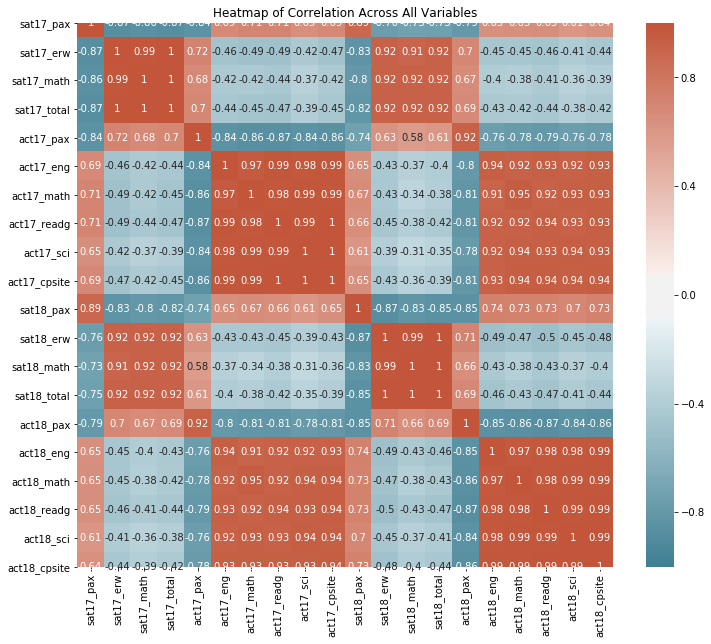

In [82]:
fig, ax = plt.subplots(figsize=(12,10))
ax.set_title('Heatmap of Correlation Across All Variables')
cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)                  
sns.heatmap(final.corr(), vmin=-1, vmax=1, center=0, cmap=cmap, annot=True); #can also toggle param annot=True

*OBSERVATIONS JUST BASED ON CORRELATION HEATMAP*

*strong positive correlations between:* 
- ERW and Total SAT scores
- Math and Total SAT scores

*strong negative correlations between:*
- ACT and SAT participation rates
- ACT English and ACT participation rate (2017)
- ACT participation rate and SAT Composite (2017)
- SAT participation rate and SAT Total (2017 and 2018)
- (SAT ERW and SAT participation rate)
- (SAT Math and SAT participation rate)

*there's strong indication that*
- participation in ACT has negative relation to the participation in SAT
- the higher the mean total scores in an SAT, the lower the state's participation rate

### Histograms

Define a custom function to subplot histograms

We have data for two tests for two years. We only have composite (and not subtest scores) for the 2018 ACT. We should write a function that will take the names of 2+ columns and subplot histograms. While you can use pandas plotting or Seaborn here, matplotlib gives you greater control over all aspects of your plots.

[Helpful Link for Plotting Multiple Figures](https://matplotlib.org/users/pyplot_tutorial.html#working-with-multiple-figures-and-axes)

Here's some starter code:

In [83]:
def subplot_histograms(dataframe, list_of_columns, list_of_titles, list_of_xlabels):
    nrows = int(np.ceil(len(list_of_columns)/2)) # Makes sure you have enough rows
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(10,10)) # You'll want to specify your figsize
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    for i, column in enumerate(list_of_columns): # Gives us an index value to get into all our lists
        ax[i].hist(dataframe[column]) # feel free to add more settings
        ax[i].set_title(list_of_titles[i]) # feel free to add more settings
        ax[i].set_xlabel(list_of_xlabels[i])

#### Plot and interpret histograms 
For each of the following:
- Participation rates for SAT & ACT
- Math scores for SAT & ACT
- Reading/verbal scores for SAT & ACT

##### Participation rates for SAT & ACT

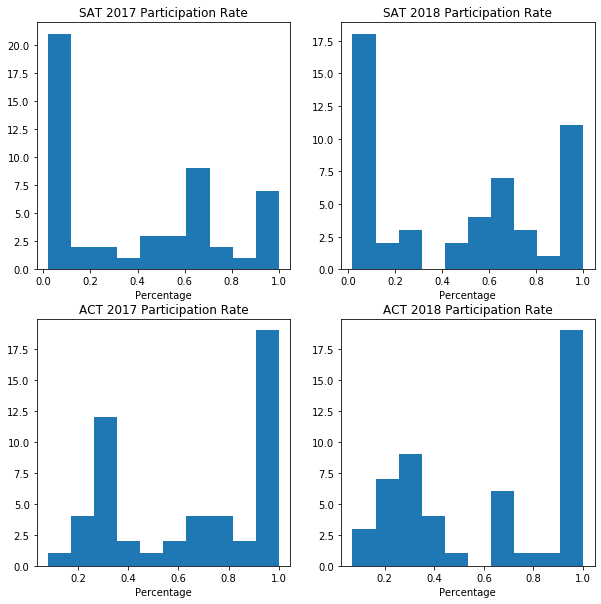

In [84]:
list_of_columns = ['sat17_pax', 'sat18_pax', 'act17_pax', 'act18_pax']
list_of_titles = ['SAT 2017 Participation Rate','SAT 2018 Participation Rate',
                  'ACT 2017 Participation Rate','ACT 2018 Participation Rate']
list_of_xlabels = ['Percentage' for i in range(4)]
subplot_histograms(final, list_of_columns, list_of_titles, list_of_xlabels)

In [ ]:
### It's difficult to compare across SAT scores when the two plots don't share the same y-axis scaling.
### Scaling should be consistent for comparison to be meaningful.
### The additional kwarg (keyword argument) that needs to be specified in the function
### should be plt.subplots(..., sharey='row') for it to share the y-axes across subplot rows.
### Otherwise nice plots.

- *Participation rates for SAT and ACT show opposite trends. There tends to be a lot more states participating in ACT than in SAT*

##### Math scores for SAT & ACT

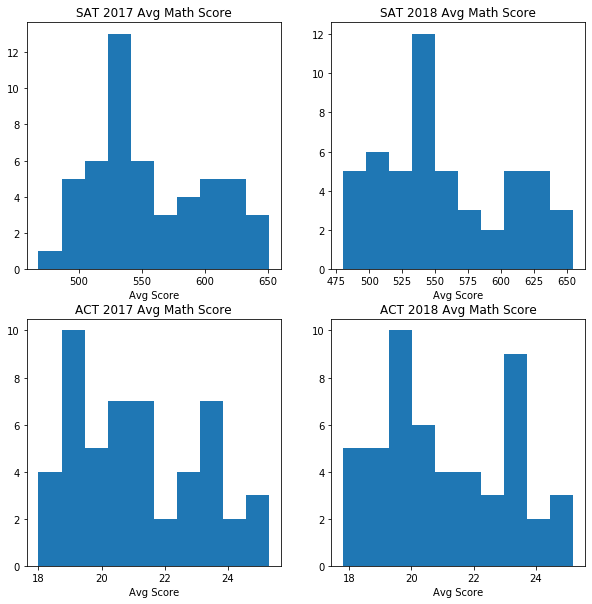

In [85]:
list_of_columns = ['sat17_math', 'sat18_math', 'act17_math', 'act18_math']
list_of_titles = ['SAT 2017 Avg Math Score','SAT 2018 Avg Math Score','ACT 2017 Avg Math Score','ACT 2018 Avg Math Score']
list_of_xlabels = ["Avg Score" for i in range(4)]
subplot_histograms(final, list_of_columns, list_of_titles, list_of_xlabels)

##### Reading/Verbal for SAT & ACT

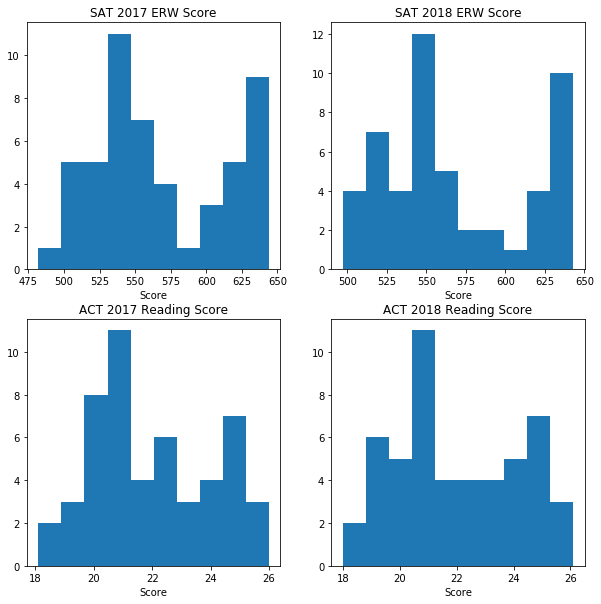

In [86]:
list_of_columns = ['sat17_erw', 'sat18_erw', 'act17_readg', 'act18_readg']
list_of_titles = ['SAT 2017 ERW Score','SAT 2018 ERW Score','ACT 2017 Reading Score','ACT 2018 Reading Score']
list_of_xlabels = ['Score' for i in range(4)]
subplot_histograms(final, list_of_columns, list_of_titles, list_of_xlabels)

### Scatter Plots

Plot and interpret scatter plots

For each of the following:
- SAT vs. ACT math scores for 2017
- SAT vs. ACT verbal/reading scores for 2017
- SAT vs. ACT total/composite scores for 2017
- Total scores for SAT 2017 vs. 2018
- Composite scores for ACT 2017 vs. 2018

Plot the two variables against each other using matplotlib or Seaborn

Your plots should show:
- Two clearly labeled axes
- A proper title
- Using colors and symbols that are clear and unmistakable

**Feel free to write a custom function, and subplot if you'd like.** Functions save both time and space.


In [87]:
def subplot_scatter(dataframe, list_of_columns, list_of_titles, list_of_xlabels):
    nrows = int(np.ceil(len(list_of_columns)/3)) # Makes sure you have enough rows
    fig, ax = plt.subplots(nrows=nrows, ncols=3, figsize=(15,10)) # You'll want to specify your figsize
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    for i, column in enumerate(list_of_columns): # Gives us an index value to get into all our lists
        ax[i].scatter(dataframe[column[0]], dataframe[column[1]]) # feel free to add more settings
        ax[i].set_title(list_of_titles[i]) # feel free to add more settings
        ax[i].set_xlabel(list_of_xlabels[i])

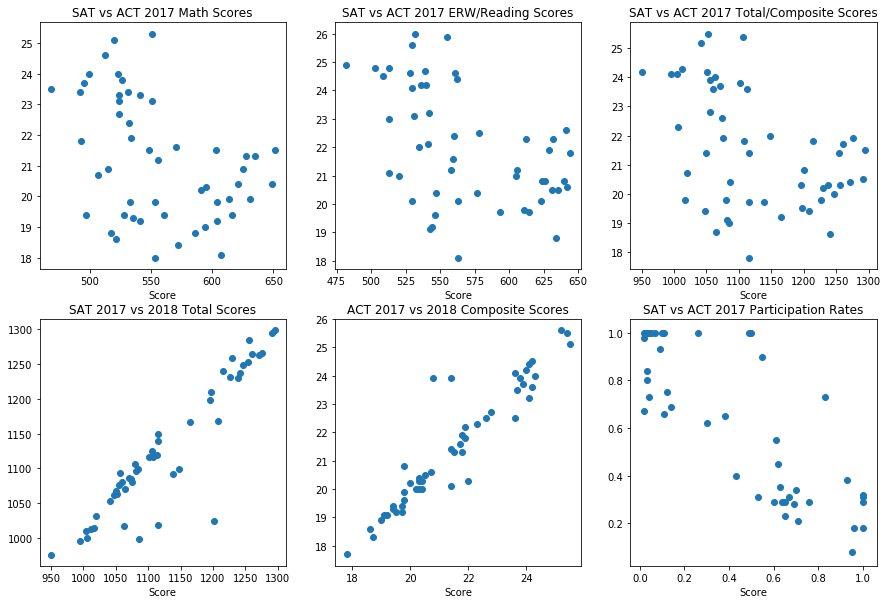

In [88]:
list_of_columns = [('sat17_math', 'act17_math'), ('sat17_erw','act17_readg'),
                   ('sat17_total', 'act17_cpsite'), ('sat17_total', 'sat18_total'), 
                   ('act17_cpsite', 'act18_cpsite'), ('sat17_pax', 'act17_pax')]
list_of_titles = ['SAT vs ACT 2017 Math Scores', 'SAT vs ACT 2017 ERW/Reading Scores',
                  'SAT vs ACT 2017 Total/Composite Scores', 'SAT 2017 vs 2018 Total Scores',
                  'ACT 2017 vs 2018 Composite Scores', 'SAT vs ACT 2017 Participation Rates']
list_of_xlabels = ['Score' for i in range(len(list_of_titles))]
subplot_scatter(final, list_of_columns, list_of_titles, list_of_xlabels)

In [ ]:
### Underperformers/overperformers are not immediately obvious from the math/math and reading/erw plots.
### drawing a 2018 = 2017 (y=x) line and annotating the outliers would help with 
### the visualisation. States in the region above would have total_2018 > total_2017. Annotation can be
### done using matplotlib.pyplot.annotate (see documentation).

##### SAT vs. ACT math scores for 2017

- *Does not appear to be a linear relationship between the reading scores in SAT and reading scores in ACT for the year 2017*

##### SAT vs. ACT total/composite scores for 2017

- *Does not appear to be a linear relationship between the total score in SAT and composite score in ACT for the year 2017*

- *Infer: Results of ACT test has no relationship with the results of the SAT test*

- *We are not able to use any ACT test results to predict the outcome of any SAT test results*

##### Total scores for SAT 2017 vs. 2018

- *Plot shows a strong linear relationship between the total score in 2017 SAT and total score in 2018 SAT for each state*
- *There seems to be 2 states in which the mean total score for 2018 has decreased/increased significantly from 2017 (bottom right of the scatter plot above) that might be good to study*
- *#Export dataset to Tableau for easier referencing and check these 2 states out in Tableau*

##### Composite scores for ACT 2017 vs. 2018

- *Plot shows a strong linear relationship between the composite score in 2017 ACT and composite score in 2018 ACT*
- *This shows that a particular state with high ACT in 2017 will show a high score in 2018, same goes for the low scorers*
- *Again here, 2 states seem to show a significant difference between the scores in 2017 and 2018* 
- *#find out through Tableau which of the states are these 2 - do they coincide with the 2 states in the SAT scatterplot above? Why?*

### Boxplots

Plot and interpret boxplots

For each numeric variable in the dataframe create a boxplot using Seaborn. Boxplots demonstrate central tendency and spread in variables. In a certain sense, these are somewhat redundant with histograms, but you may be better able to identify clear outliers or differences in IQR, etc.

Multiple values can be plotted to a single boxplot as long as they are of the same relative scale (meaning they have similar min/max values).

Each boxplot should:
- Only include variables of a similar scale
- Have clear labels for each variable
- Have appropriate titles and labels

In [89]:
final.columns

Index(['state', 'sat17_pax', 'sat17_erw', 'sat17_math', 'sat17_total',
       'act17_pax', 'act17_eng', 'act17_math', 'act17_readg', 'act17_sci',
       'act17_cpsite', 'sat18_pax', 'sat18_erw', 'sat18_math', 'sat18_total',
       'act18_pax', 'act18_eng', 'act18_math', 'act18_readg', 'act18_sci',
       'act18_cpsite'],
      dtype='object')

In [90]:
numeric_cols = ['sat17_pax', 'sat17_erw', 'sat17_math', 'sat17_total',
                'act17_pax', 'act17_eng', 'act17_math', 'act17_readg', 'act17_sci',
                'act17_cpsite', 'sat18_pax', 'sat18_erw', 'sat18_math', 'sat18_total',
                'act18_pax', 'act18_eng', 'act18_math', 'act18_readg', 'act18_sci',
                'act18_cpsite']

pax_ = ['sat17_pax', 'sat18_pax', 'act17_pax', 'act18_pax']
total_ = ['sat17_total', 'sat18_total']
cpsite_ = ['act17_cpsite', 'act18_cpsite']
sat_subj_ =  ['sat17_erw', 'sat17_math', 'sat18_erw', 'sat18_math' ]
act_subj_ =  ['act17_eng', 'act17_math', 'act17_readg', 'act17_sci',
              'act18_eng', 'act18_math', 'act18_readg', 'act18_sci']

collection_ = [pax_, total_, cpsite_, sat_subj_, act_subj_]
titles_ = ["Participation Rates", "SAT Total Scores", "ACT Composite Scores", "SAT Component Scores", "ACT Component Scores"]

In [91]:
def subplot_boxplot(dataframe, list_of_columns, list_of_titles):    
    fig = plt.figure(figsize=(15,15))                        ### Notice how the image is slightly blurred? 
    ncols=                                                   ### You can avoid this by forcing the dpi 
    nrows=2                                                  ### ax = plt.figure(dpi-160, figsize=(15,15))   
    for i, col in enumerate(list_of_columns):
        ax = plt.subplot(ncols,nrows,i+1)
        ax.set_title(list_of_titles[i])
        locs, labels = plt.xticks() #
        plt.setp(labels, rotation=15) #
        sns.boxplot(data=dataframe[col], ax=ax)

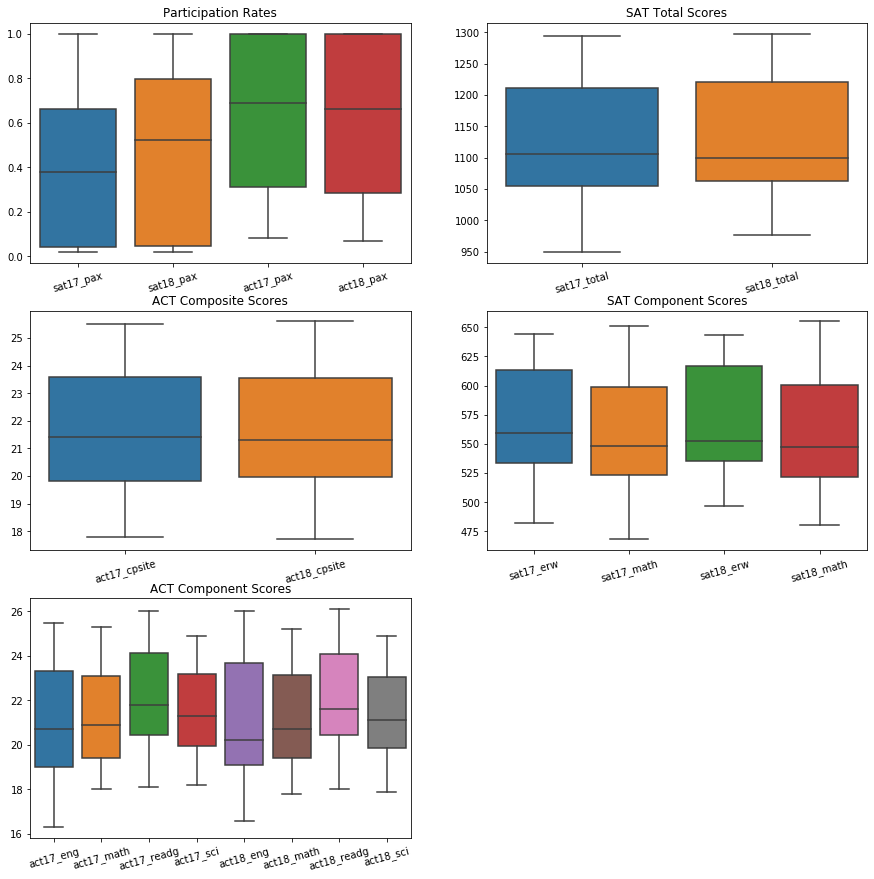

In [92]:
subplot_boxplot(final, collection_, titles_)

##### Observations
- *(Participation Rates) Higher participation rates of states in the ACT than in the SAT*
- *(SAT Total Scores) Remain stable from 2017 to 2018*
- *(ACT Composite Scores) Remain stable from 2017 to 2018*
- *(SAT Subject Scores) Lower Math scores than ERW scores in the SAT*
- *(ACT Subject Scores) Greater range of scores in English component than other components, Higher scores in Reading component than other components in the ACT*

### Additional Plots

Feel free to do additional plots below
*(do research and choose your own chart types & variables)*

Are there any additional trends or relationships you haven't explored? Was there something interesting you saw that you'd like to dive further into? It's likely that there are a few more plots you might want to generate to support your narrative and recommendations that you are building toward. **As always, make sure you're interpreting your plots as you go**.

In [93]:
%%HTML
<div class='tableauPlaceholder' id='viz1573432117251' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;SA&#47;SAT-ACT-2017-2018-US-States-Participation-Rates&#47;4Maps&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='SAT-ACT-2017-2018-US-States-Participation-Rates&#47;4Maps' /><param name='tabs' value='yes' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;SA&#47;SAT-ACT-2017-2018-US-States-Participation-Rates&#47;4Maps&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1573432117251');                    var vizElement = divElement.getElementsByTagName('object')[0];                    if ( divElement.offsetWidth > 800 ) { vizElement.style.minWidth='420px';vizElement.style.maxWidth='100%';vizElement.style.minHeight='610px';vizElement.style.maxHeight=(divElement.offsetWidth*0.75)+'px';} else if ( divElement.offsetWidth > 500 ) { vizElement.style.minWidth='420px';vizElement.style.maxWidth='100%';vizElement.style.minHeight='610px';vizElement.style.maxHeight=(divElement.offsetWidth*0.75)+'px';} else { vizElement.style.width='100%';vizElement.style.minHeight='1300px';vizElement.style.maxHeight=(divElement.offsetWidth*1.77)+'px';}                     var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

In [ ]:
### Very nice. 

##### Observations (Click on the '4Maps' Tableau tab above)
- *As observed in Participation Rates boxplots of SAT and ACT, and (ACT 2017 Map above), a much greater sizeable portion of the US states, particularly the North, Central and Mid-West and South-East use the ACT*
- *whereas the SAT is taken up mainly by states in the fringes of US (SAT 2017 Map), except Oregon, North Carolina, South Carolina, and Arizona*
- *However, (SAT 2017 & SAT 2018 Maps) Colorado and Illinois have seen a successful conversion from the SAT to the ACT (ACT 2017 & ACT 2018 Maps) going from 2017 to 2018 - a complete switch from 93-100% ACT participation to 99-100% SAT take-ups (only 9-11% in 2017)*
- *North Carolina and South Carolina have seen a slight increase in SAT participations but ACT participations remain at 100% both years - hence states like these might not be worth considering unless their contracts with ACT are ending soon as in Colorado and Illinois*

## Descriptive and Inferential Statistics

### Summarizing Distributions

Above, we used pandas `describe` to provide quick summary statistics of our numeric columns. We also demonstrated many visual relationships.

As data scientists, having a complete understanding of data is imperative prior to modeling.

While we will continue to build our analytic tools, we know that measures of *central tendency*, *spread*, and *shape/skewness* provide a quick summary of distributions.

For each variable in your data, summarize the underlying distributions (in words & statistics)
 - Be thorough in your verbal description of these distributions.
 - Be sure to back up these summaries with statistics.

Answers:

### Normal Distribution Trends

We generally assuming that data we sample from a population will be normally distributed. Do we observe this trend?

*OBSERVATIONS*

- *From the Boxplots, it can be observed that test components do show general central tendency looking at the inter-quartile ranges of each component*
- *However, each component shows a right skew with higher numbers of lower scores compared to higher scores*
- *Normal distributions cannot be said to hold true for Rates*

### Estimation of Limits of Data

Suppose we only seek to understand the relationship between SAT and ACT participation rates in 2017. 

##### Does it make sense to conduct statistical inference given these data specifically? 

Why or why not?

*(think about granularity, aggregation, the relationships between populations size & rates...consider the actually populations these data describe in answering this question)*

Answer:

In [ ]:
### You missed this! It's still ok if you relax some of the strict assumptions. 

##### Is it appropriate to compare *these* specific SAT and ACT math scores? 

Why or why not?

Answer:

In [ ]:
### You missed this! If you treat scores as ordinal variables this is still posible.

### Statistical Evaluation of Distributions 

**If you feel it's appropriate**, using methods we discussed in class, run hypothesis tests to compare variables of interest in our dataset. 

In [94]:
### Would have liked to see Shapiro Wilks to check for normality, or similar

## Outside Research

Based upon your observations, choose **three** states that demonstrate interesting trends in their SAT and/or ACT participation rates. Spend some time doing outside research on state policies that might influence these rates, and summarize your findings below. **Feel free to go back and create new plots that highlight these states of interest**. If you bring in any outside tables or charts, make sure you are explicit about having borrowed them. If you quote any text, make sure that it renders as being quoted. (Make sure that you cite your sources -- check with you local instructor for citation preferences).

STATES with 100% ACT Rates #out of curiosity
- [12 states that require every junior to take the test and eight more that either require the test in some districts or offer it as a free option for students who wish to take it](https://blog.prepscholar.com/which-states-require-the-act-full-list-and-advice) 21 Jul 2019

COLORADO/ILLINOIS
- switch from ACT to [SAT state's mandate](https://www.testive.com/colorado-sat-change-2017/) with the College Board to administer the SAT to all high school students, [same goes for Illinois](https://www.chicagotribune.com/news/ct-illinois-chooses-sat-met-20160211-story.html)
- College Board may ride on such successful conversions on new states

OREGON
- [Smarter Balanced assessment introduced to all public schools in Oregon since 2015](https://sos.oregon.gov/audits/documents/2016-21.PDF) (no contract with ACT or SAT)
- Oregon Department of Education decided to drop Smarter Balanced assessments for high school beginning in 2018-19 and replace with either ACT or SAT. [Stakeholders (teachers) resistant against implementation, ODE recanted its decision](https://www.oregon.gov/ode/educator-resources/assessment/Documents/HS_Assessment_Report.pdf) 
- [$5.8 – 6.8 million every 2 years in implementation](https://deutsch29.wordpress.com/2018/07/14/oregon-high-schools-smarter-balanced-no-wait-act-sat-no-wait-smarter-balanced-but-those-opt-outs/amp/)

CALIFORNIA
- SAT rates (53->60%) show an increase while ACT rates (31->27%) decrease
- [high number of reputable and top-ranking universities in California](https://www.4icu.org/us/california/)
- high number of SAT takers among US states (262,228) in 2018
- College Board should ride on the strategic location of the state and implement [SAT School Day](https://collegereadiness.collegeboard.org/sat/k12-educators/sat-school-day/about) to provide free tests for students of lower income within their own school premises

## Conclusions and Recommendations

Based on your exploration of the data, what are you key takeaways and recommendations? Choose one state with a lower participation rate and provide a suggestion for how the College Board might increase participation amongst graduating seniors in this state. Are there additional data you desire that would better inform your investigations?

- In view of the difficulties facing Oregon's state with their stakeholders, it will be a better choice to push SAT to California given the location of highly ranked universities among the US (UCLA, Standford, CIT), its already high number of take-ups in SAT among other states, and its increasing take-up rates
- College Board could implement policies like the SAT School Day to allow students of lower income the opportunity to take these tests without feeling discriminated against